# CIV250 - Weather Data Analysis

In this exercise, we're going to demonstrate the capabilities of Python to not only process large amounts of data, but construct interesting and thoughtful figures. First, we will need the following packages:

In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time

We're going to be examining data from the TRCA: this is a repository of data from various weather stations across the GTA. Click [here](https://data.trca.ca/dataset/precipitation) to access the precipitation data, and select "Explore" and "Preview" for one of the data files:

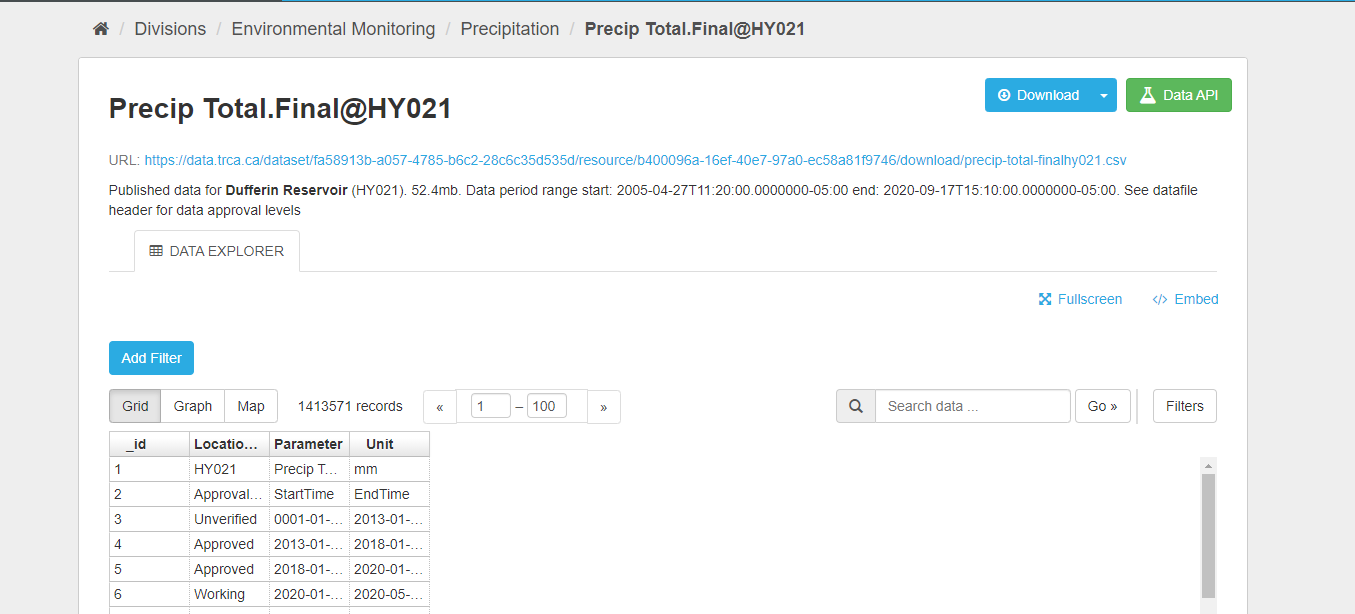

Click "Download". It's a big file - over 50 MB - and in fact Excel can't even fully open it! I was only able to view data up to 2017. Python can though, so save the csv file on your computer and upload it into the Jupyter folder. Then, run the following code to bring it into Python, making sure to name the file 'weather_data':

In [394]:
#Bring csv file to Python environment
precip_data = pd.read_csv('weather_data.csv')
precip_data

C:\Users\itaia\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LocationIdentifier,Parameter,Unit
0,HY002,Precip Total,mm
1,ApprovalLevel,StartTime,EndTime
2,Unverified,0001-01-01T00:00:00.0000000+00:00,2013-01-01T00:00:00.0000000-05:00
3,Approved,2013-01-01T00:00:00.0000000-05:00,2018-04-02T03:00:00.0000000-05:00
4,Approved,2018-04-02T03:00:00.0000000-05:00,2019-05-02T11:15:00.0000000-05:00
...,...,...,...
1424104,2020-09-17T15:15:00.0000000-05:00,0,NaN
1424105,2020-09-17T15:20:00.0000000-05:00,0,NaN
1424106,2020-09-17T15:25:00.0000000-05:00,0,NaN
1424107,2020-09-17T15:30:00.0000000-05:00,0,NaN


Once again, we're going to need to do some basic clean-up on this data before we can work on it. First, get rid of the title block (you may need to change the number of rows removed depending on your dataset):

In [400]:
#Delete unnecessary rows
precip_data = precip_data.iloc[3:] #You may need to change the leading integer
precip_data

,LocationIdentifier,Parameter,Unit
18,2004-10-27T15:50:00.0000000-05:00,0,NaN
19,2004-10-27T15:55:00.0000000-05:00,0,NaN
20,2004-10-27T16:00:00.0000000-05:00,0,NaN
21,2004-10-27T16:05:00.0000000-05:00,0,NaN
22,2004-10-27T16:10:00.0000000-05:00,0,NaN
...,...,...,...
1424104,2020-09-17T15:15:00.0000000-05:00,0,NaN
1424105,2020-09-17T15:20:00.0000000-05:00,0,NaN
1424106,2020-09-17T15:25:00.0000000-05:00,0,NaN
1424107,2020-09-17T15:30:00.0000000-05:00,0,NaN


You should see "LocationIdentifier", "Parameter", and "Unit" as your column headers. Let's continue to clean up this data by dropping the "Unit" column and renaming the others, amd convert the "precip" column to floats, since they're read as strings here as well:

In [401]:
#Delete unnecessary column
precip_data = precip_data.drop('Unit', axis=1)

#Rename columns
precip_data.columns = ['timestamp', 'precip']

#Convert precip string to float
precip_data.loc[:, 'precip'] = precip_data.loc[:, 'precip'].astype(float)

precip_data

,timestamp,precip
18,2004-10-27T15:50:00.0000000-05:00,0.0
19,2004-10-27T15:55:00.0000000-05:00,0.0
20,2004-10-27T16:00:00.0000000-05:00,0.0
21,2004-10-27T16:05:00.0000000-05:00,0.0
22,2004-10-27T16:10:00.0000000-05:00,0.0
...,...,...
1424104,2020-09-17T15:15:00.0000000-05:00,0.0
1424105,2020-09-17T15:20:00.0000000-05:00,0.0
1424106,2020-09-17T15:25:00.0000000-05:00,0.0
1424107,2020-09-17T15:30:00.0000000-05:00,0.0


If you worked through the last example, you may be familar with the [to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) method. It's quite useful here too, as it'll allow us to convert the date strings to datetime objects, which are pretty handy for pivoting. There's a bit of an issue here though: the timestamp strings have 05:00 at the end of each entry - this is likely a location tag. We can get rid of it  with the [str.slice](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.slice.html) method, after which we can proceed as before:

In [402]:
#Cut off last 6 digits in timestamp
precip_data.loc[:, 'timestamp'] = precip_data.loc[:, 'timestamp'].str.slice(stop=-6)

#Convert timestamp from string object to timestamp object
precip_data.loc[:, 'timestamp'] = pd.to_datetime(precip_data.loc[:, 'timestamp'], format='%Y-%m-%d %H:%M')

In [403]:
precip_data

,timestamp,precip
18,2004-10-27 15:50:00,0.0
19,2004-10-27 15:55:00,0.0
20,2004-10-27 16:00:00,0.0
21,2004-10-27 16:05:00,0.0
22,2004-10-27 16:10:00,0.0
...,...,...
1424104,2020-09-17 15:15:00,0.0
1424105,2020-09-17 15:20:00,0.0
1424106,2020-09-17 15:25:00,0.0
1424107,2020-09-17 15:30:00,0.0


You should see a narrow dataframe above with >1 million rows and only two columns. Now, we can proceed with some pivoting. Let's first extract the year, month, week and date from the datetime objects we set up above:

In [404]:
#Get year, month, week, date for each timestamp in the series
precip_data.loc[:,'year'] = pd.DatetimeIndex(precip_data.loc[:,'timestamp']).year
precip_data.loc[:,'month'] = pd.DatetimeIndex(precip_data.loc[:,'timestamp']).month
precip_data.loc[:, 'date'] = pd.DatetimeIndex(precip_data.loc[:,'timestamp']).date
precip_data.loc[:, 'week'] = pd.DatetimeIndex(precip_data.loc[:,'timestamp']).week

precip_data

<ipython-input-404-3379c393a0f8>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  precip_data.loc[:, 'week'] = pd.DatetimeIndex(precip_data.loc[:,'timestamp']).week


,timestamp,precip,year,month,date,week
18,2004-10-27 15:50:00,0.0,2004,10,2004-10-27,44
19,2004-10-27 15:55:00,0.0,2004,10,2004-10-27,44
20,2004-10-27 16:00:00,0.0,2004,10,2004-10-27,44
21,2004-10-27 16:05:00,0.0,2004,10,2004-10-27,44
22,2004-10-27 16:10:00,0.0,2004,10,2004-10-27,44
...,...,...,...,...,...,...
1424104,2020-09-17 15:15:00,0.0,2020,9,2020-09-17,38
1424105,2020-09-17 15:20:00,0.0,2020,9,2020-09-17,38
1424106,2020-09-17 15:25:00,0.0,2020,9,2020-09-17,38
1424107,2020-09-17 15:30:00,0.0,2020,9,2020-09-17,38


Because this data is uploaded in 5 minute increments, the vast majority of the points are zero - you can calculate how many by running the code below:

In [409]:
#Get the number of zero columns against the total
zero_precip = (precip_data.loc[:, 'precip']==0).sum()
len_precip = precip_data.shape[0]
zero_frac = round(zero_precip/len_precip*100, 2)

print(str(zero_frac) + '% of the precipitation data are zeroes')

96.45% of the precipitation data are zeroes


So we should aggregate the data somehow. Let's try aggregating the data based on total weekly precipitation to create a histogram of sorts - we can grab the sum, mean, std, and max of each period. However, look what happens if we just do a pivot table based on weeks:

In [410]:
#Pivot the data on months and calculate sum, mean, st, max, and count
week_pivot = pd.pivot_table(precip_data, values='precip', index='week', 
                             aggfunc = [sum, np.mean, np.std, max, 'count'])
week_pivot

,sum,mean,std,max,count
,precip,precip,precip,precip,precip
week,,,,,
1,138.9,0.007739,0.036988,0.6,17949
2,271.2,0.015215,0.065373,1.7,17825
3,84.5,0.004360,0.025981,0.5,19381
4,129.4,0.006445,0.032714,0.7,20077
5,131.1,0.006559,0.031244,0.6,19987
6,159.1,0.008063,0.033863,0.5,19733
7,67.4,0.003407,0.020669,0.4,19781
8,171.8,0.008569,0.043264,1.0,20050


The aggregation functions were applied for each month regardless of the year. While this is somewhat useful - we can tell what weeks of the year tend to have the highest levels of precipitation - we lose a lot of the definition we could be getting. The sum is also not a true sum of precipitation per week, rather the sum of every year's preciptation at a given month. What we really want is for the data to aggregate every week **per year**. We can do this by creating a multi-index table using the [pandas groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) method:

In [414]:
#Create aggregate features for each month and each year
week_agg_pivot = precip_data.groupby(['year', 'week']).agg(
    week_precip_tot = pd.NamedAgg('precip', 'sum'),
    week_precip_ave = pd.NamedAgg('precip', 'mean'),
    week_precip_std = pd.NamedAgg('precip', 'std'),
    week_precip_max = pd.NamedAgg('precip', 'max'),
    week_precip_cnt = pd.NamedAgg('precip', 'count'))

week_agg_pivot

week_precip_tot  week_precip_ave  week_precip_std  week_precip_max  \
year week                                                                       
2004 44                8.6         0.006880         0.086479              2.2   
     45               38.0         0.018849         0.081194              1.0   
     46                0.0         0.000000         0.000000              0.0   
     47                2.0         0.000992         0.016641              0.4   
     48               21.4         0.010615         0.055884              0.6   
...                    ...              ...              ...              ...   
2020 34                1.6         0.000794         0.012966              0.3   
     35               19.8         0.009880         0.070532              1.2   
     36               17.5         0.008681         0.096175              2.4   
     37               36.1         0.017925         0.188179              5.5   
     38                0.0         0.000000         0.000000              0.0   

           week_precip_cnt  
year week                   
2004 44               1250  
     45               2016  
     46               2016  
     47               2016  
     48               2016  
...                    ...  
2020 34               2016  
     35               2004  
     36               2016  
     37               2014  
     38               1052  

[724 rows x 5 columns]

As you can see above, each row has both a year and month index, set in order. Now, lets visualize the total precipitation per month with a histogram. This is fairly easy to do if we set everything up correctly:

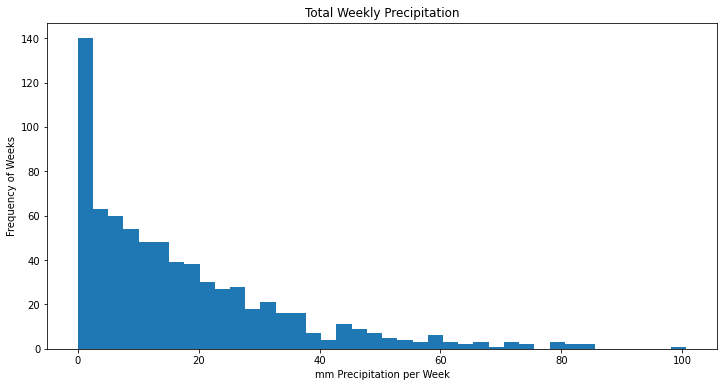

In [428]:
#Construct histogram of monthly data
plt.figure(figsize=(12,6))
ax = plt.hist(week_agg_pivot.loc[:, 'week_precip_tot'], bins=40)

#Plot titles
plt.xlabel('mm Precipitation per Week')
plt.ylabel('Frequency of Weeks')
plt.title('Total Weekly Precipitation')

plt.show()

Let's take it a step further and construct a time-series box plot. This is something made much easier with the [Seaborn](https://seaborn.pydata.org/tutorial.html) package, as long as we set up the dataframe correctly

For our example, lets aggregate the total weekly precipitation and set up box plots for each. We can again do this with a pivot table. If we check the documentation for [Seaborn box plots](https://seaborn.pydata.org/generated/seaborn.boxplot.html), we see we need a table with two columns: an x for the time series (in this case years) and a y for the actual data (the total weekly precipitation). We do this below:

In [419]:
#Generate multi-index table with year and week, summing each week's precipitation (y column)
boxplot_pivot = precip_data.pivot_table(index=['year','week'], aggfunc='sum')

#Get year value of each week (x column) 
boxplot_pivot.loc[:,'Year'] = boxplot_pivot.index.get_level_values('year')

#Drop additional axis to match Seaborn formatting and rename axes
boxplot_pivot = boxplot_pivot.drop(columns=['month'], axis=1)
boxplot_pivot.rename(columns={'precip':'Cumulative Precipitation per Week (mm)'}, inplace=True)

boxplot_pivot

Cumulative Precipitation per Week (mm)  Year
year week                                              
2004 44                                       8.6  2004
     45                                      38.0  2004
     46                                       0.0  2004
     47                                       2.0  2004
     48                                      21.4  2004
...                                           ...   ...
2020 34                                       1.6  2020
     35                                      19.8  2020
     36                                      17.5  2020
     37                                      36.1  2020
     38                                       0.0  2020

[724 rows x 2 columns]

Now with the above matrix, we can input the code for the Seaborn box plot:

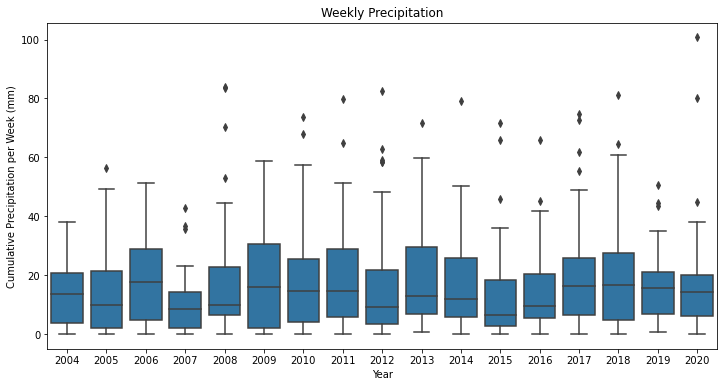

In [420]:
#Construct time-series box plot
plt.figure(figsize=(12,6))
ax = sns.boxplot(data = boxplot_pivot, y='Cumulative Precipitation per Week (mm)', x='Year', color='tab:blue')
plt.title('Weekly Precipitation')
plt.show()

See if you can create your own plot below.